# Прогнозирование заказов такси

# Подготовка

## Импорт библиотек

In [1]:
!pip install optuna -q

In [2]:
!pip install optuna-dashboard -q

In [3]:
!pip install xgboost -q

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

import optuna
import xgboost as xgb

## Импорт данных

In [6]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

## Анализ

In [7]:
data = data.sort_index()

In [8]:
data.index.is_monotonic_increasing

True

Временной ряд в данных непрерывный

In [9]:
data = data.resample('1H').sum()

In [10]:
sns.set(rc={'figure.figsize':(25,10)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

## Анализ тренда в общем временном промежутке

In [11]:
df = data.resample('1H').sum()

In [12]:
decomposed = seasonal_decompose(df)

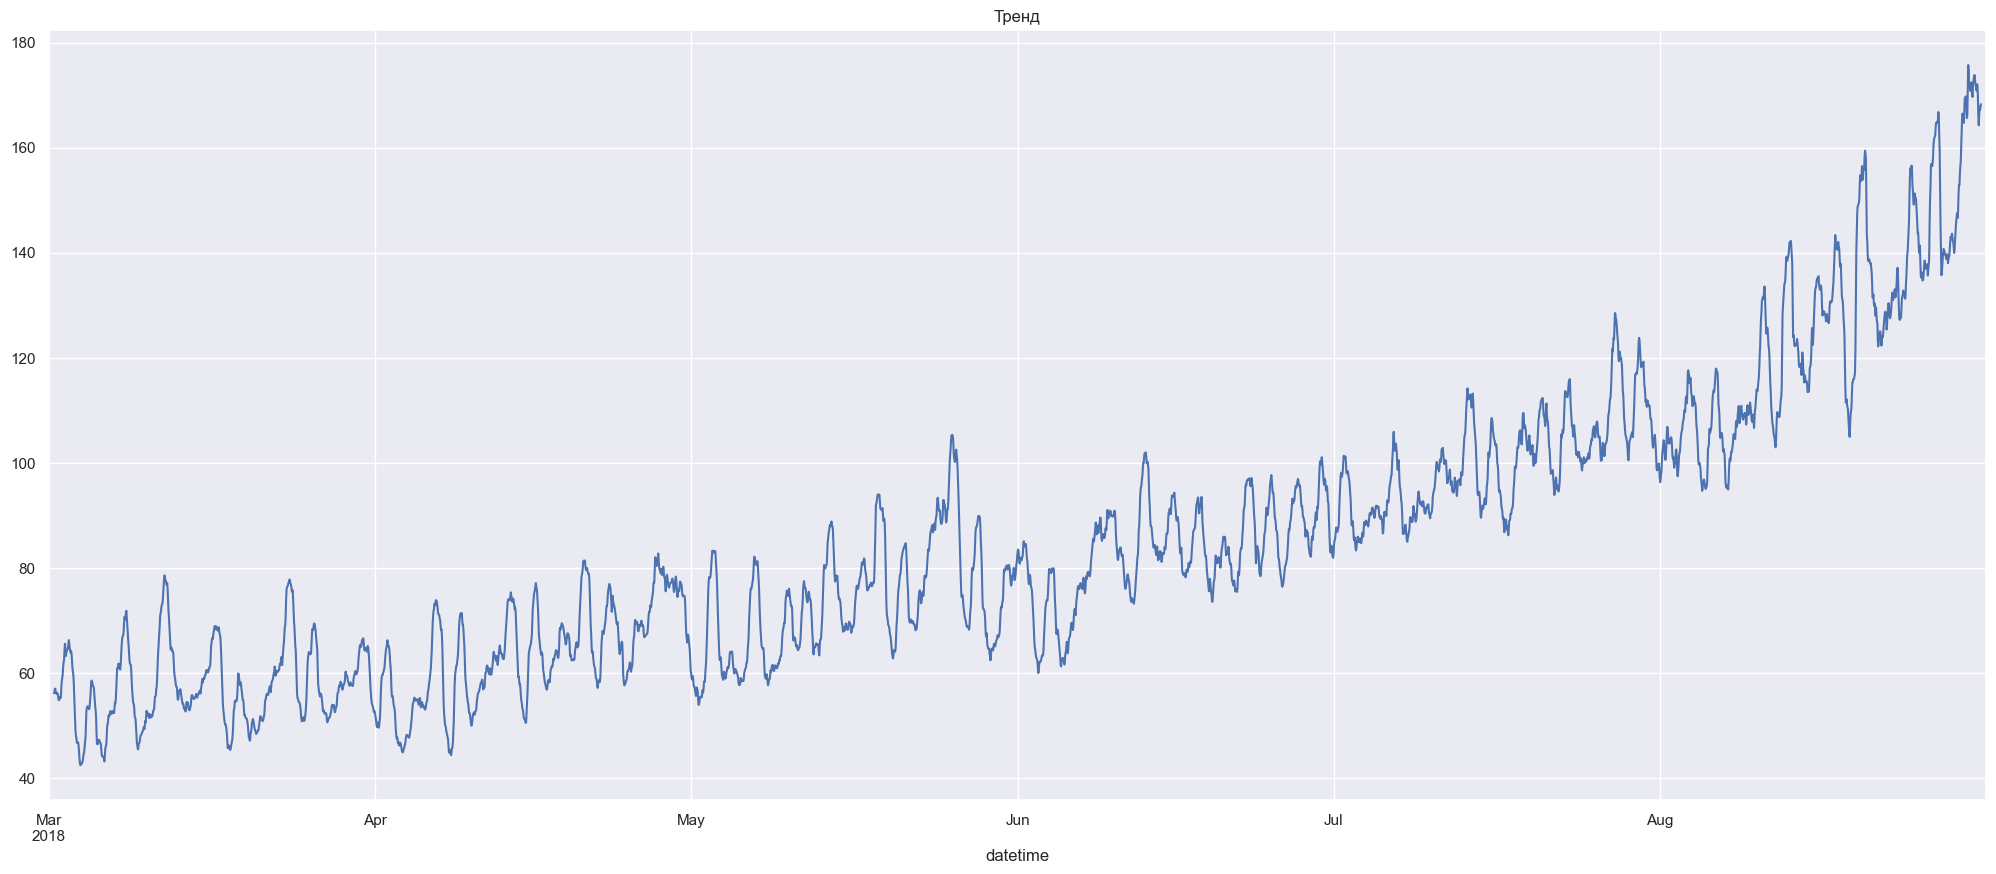

In [13]:
lineplot(decomposed.trend, 'Тренд')

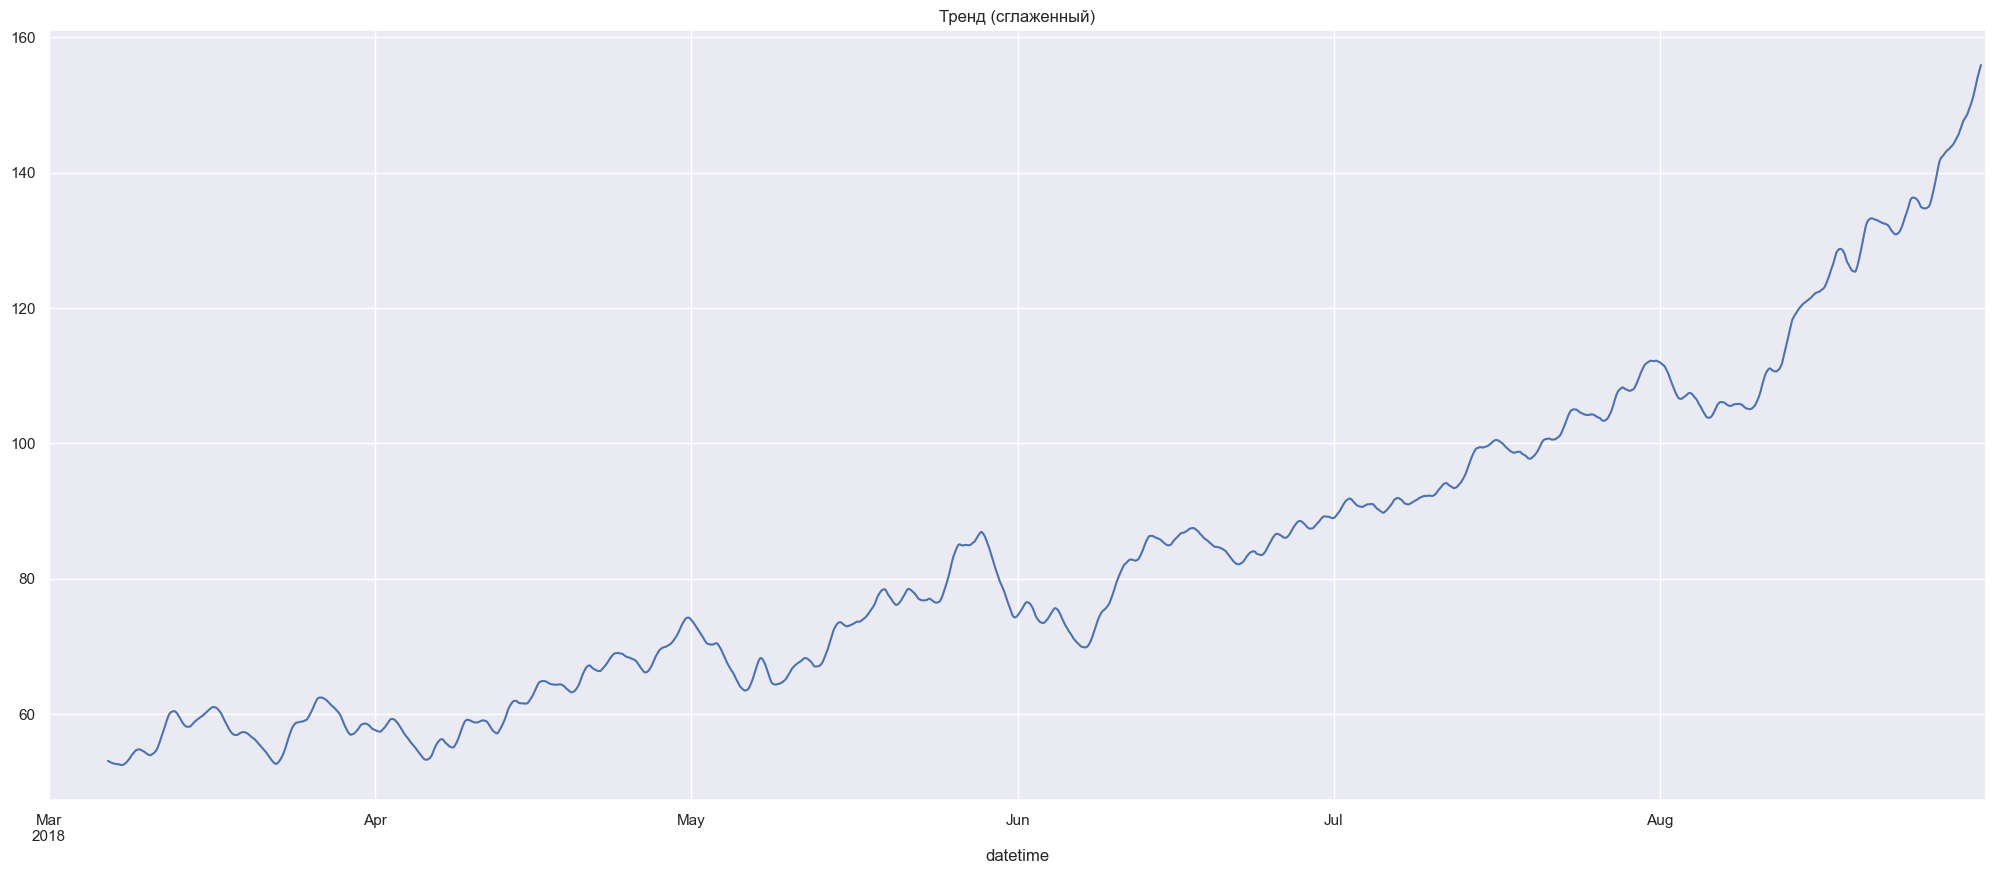

In [14]:
lineplot(decomposed.trend.rolling(124).mean(), 'Тренд (сглаженный)')

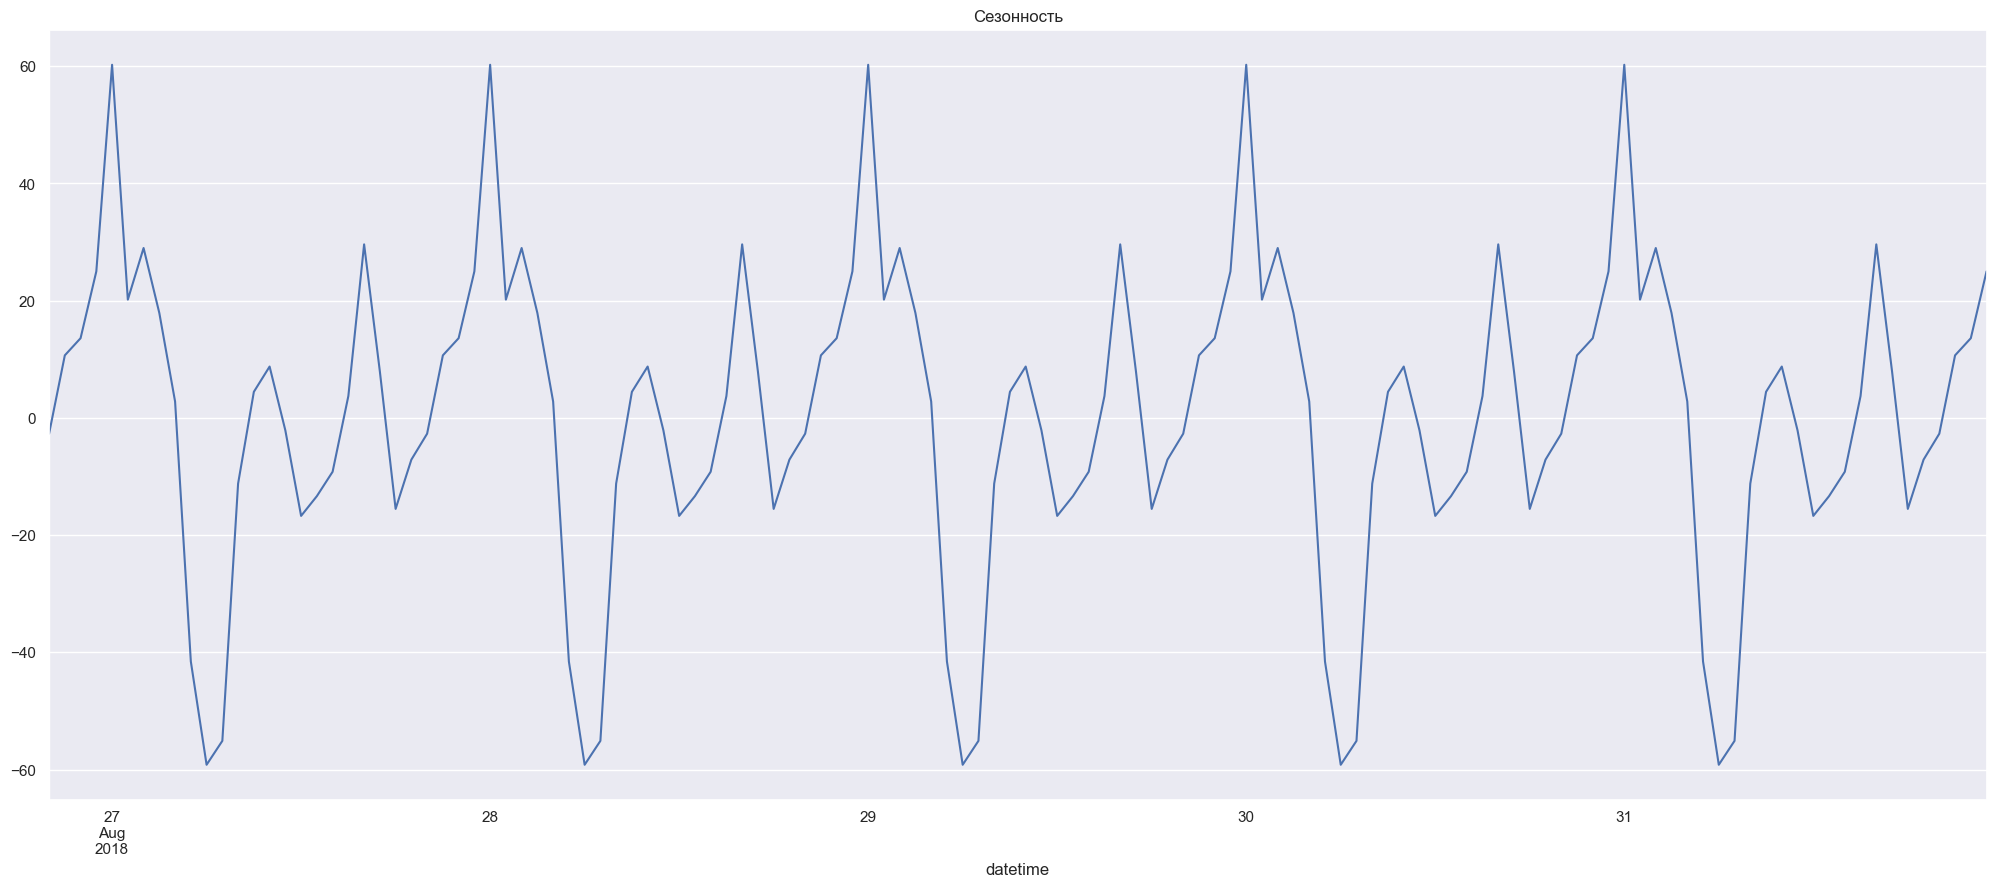

In [15]:
lineplot(decomposed.seasonal.tail(124), 'Сезонность')

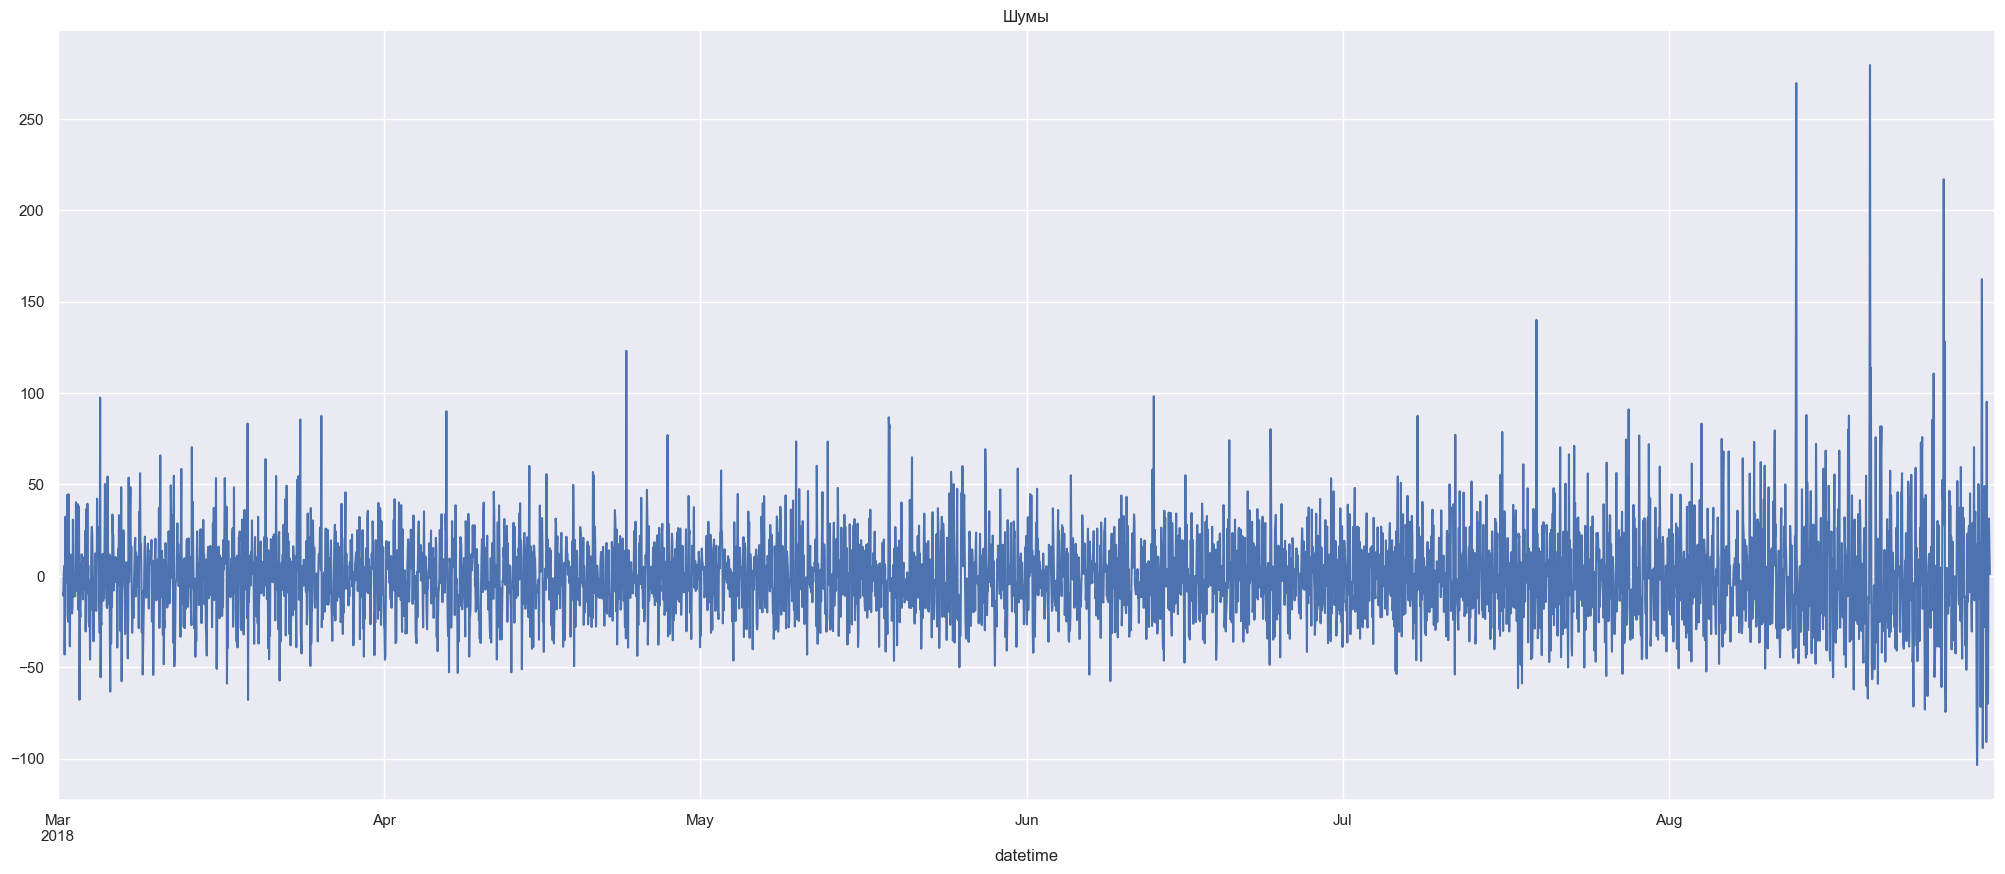

In [16]:
lineplot(decomposed.resid, 'Шумы')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


В данных содержится временной промужок с 1 марта по 31 августа 2018 года

In [18]:
data.isna().mean()

num_orders    0.0
dtype: float64

Пропусков в данных нет

## Анализ временного ряда в промежутке Августа

Посмотрим дополнительно на сезонность в разрезе Августа

In [19]:
decomposed_aug = seasonal_decompose(df['2018-08-01':'2018-08-31'])

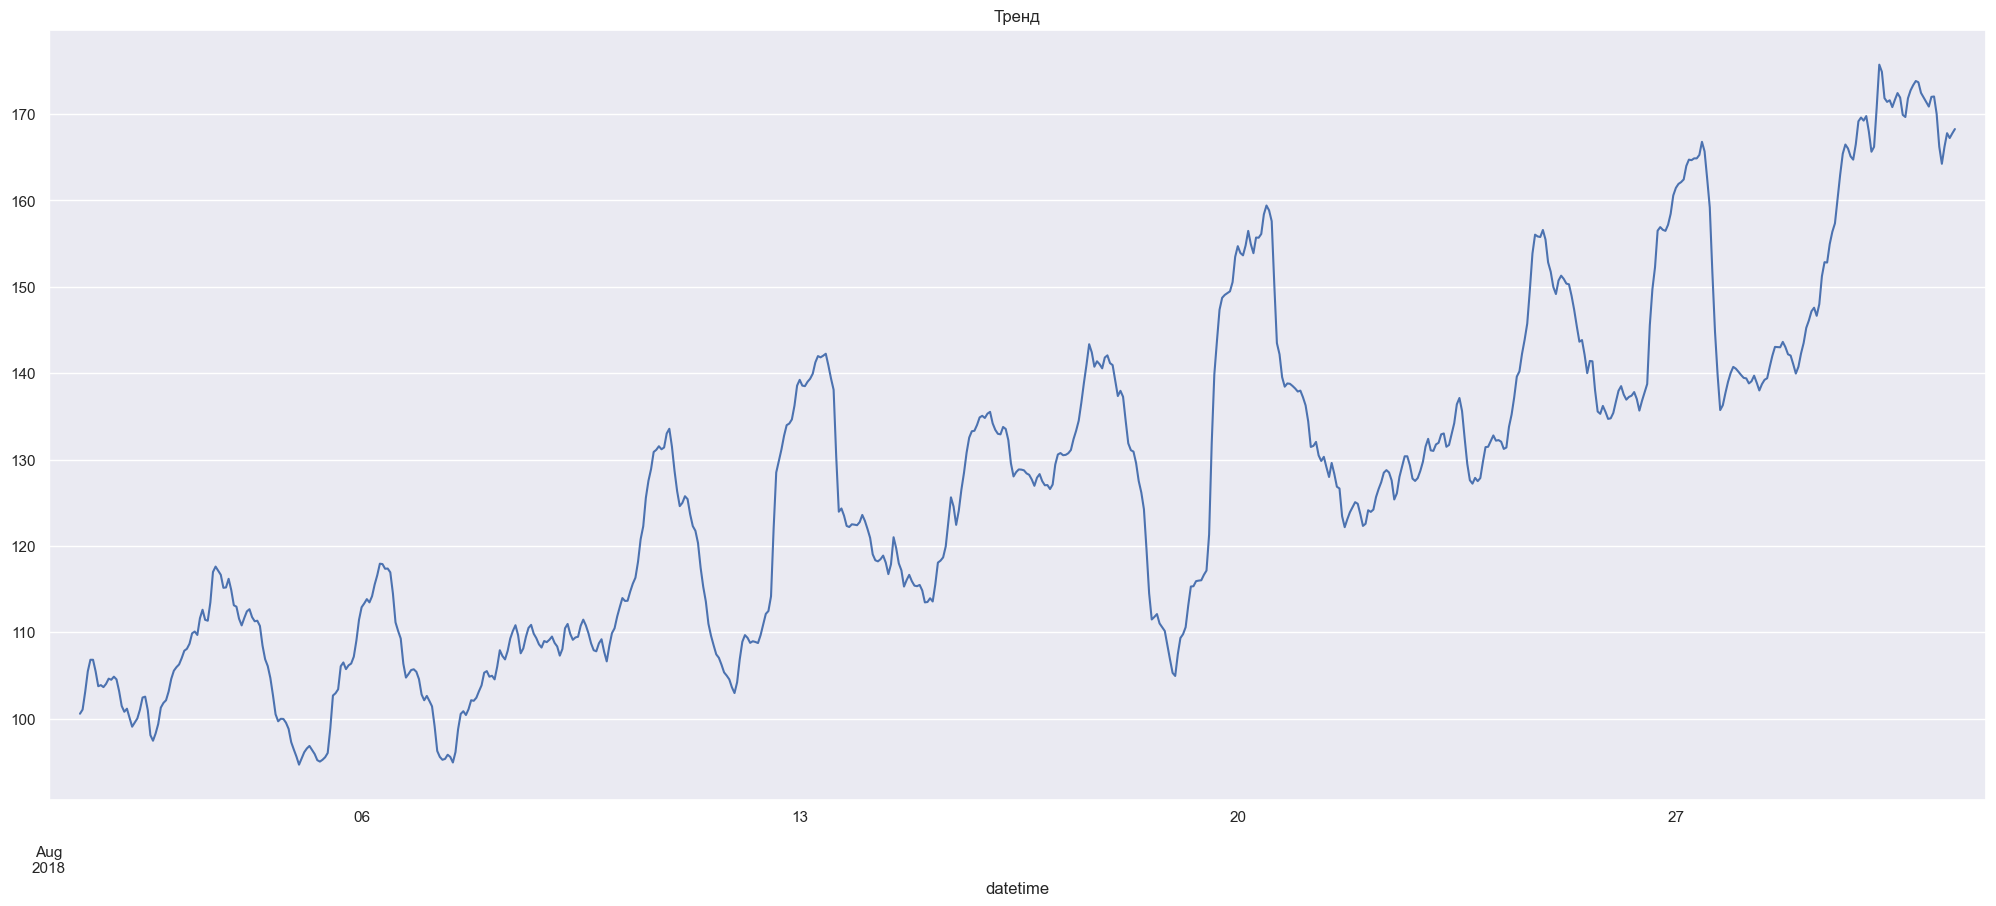

In [20]:
lineplot(decomposed_aug.trend, 'Тренд')

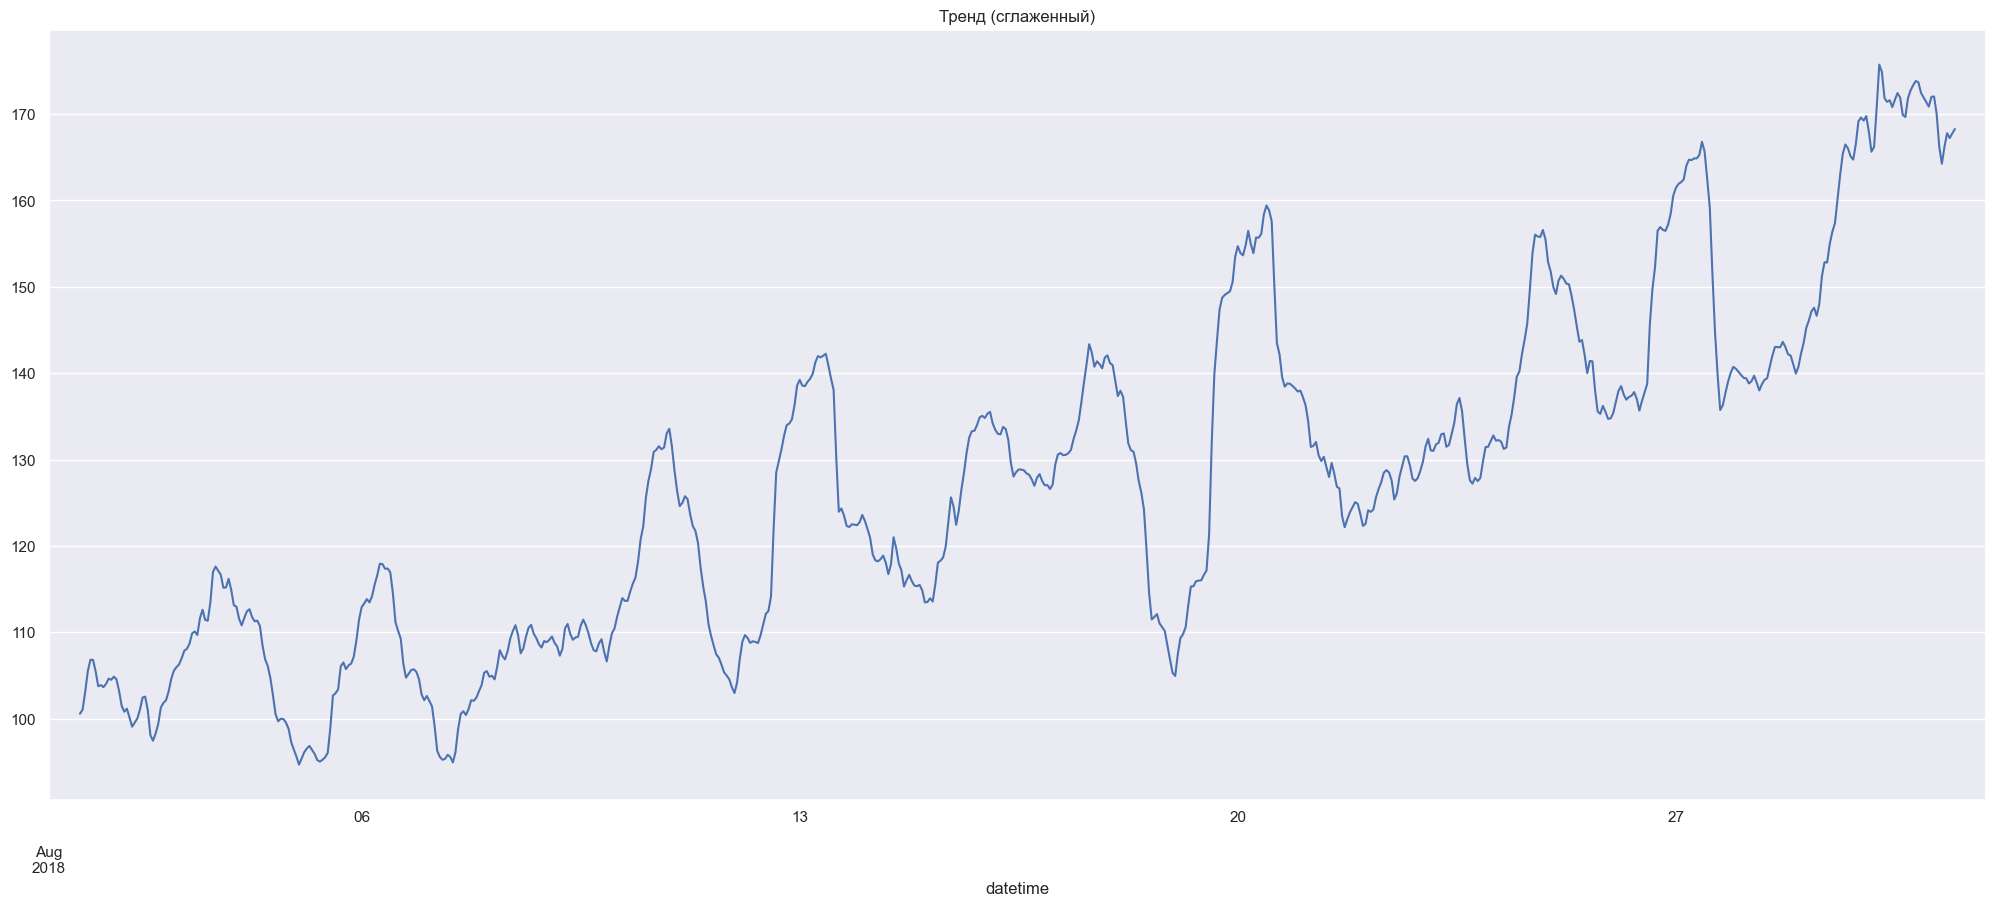

In [21]:
lineplot(decomposed_aug.trend.rolling(1).mean(), 'Тренд (сглаженный)')

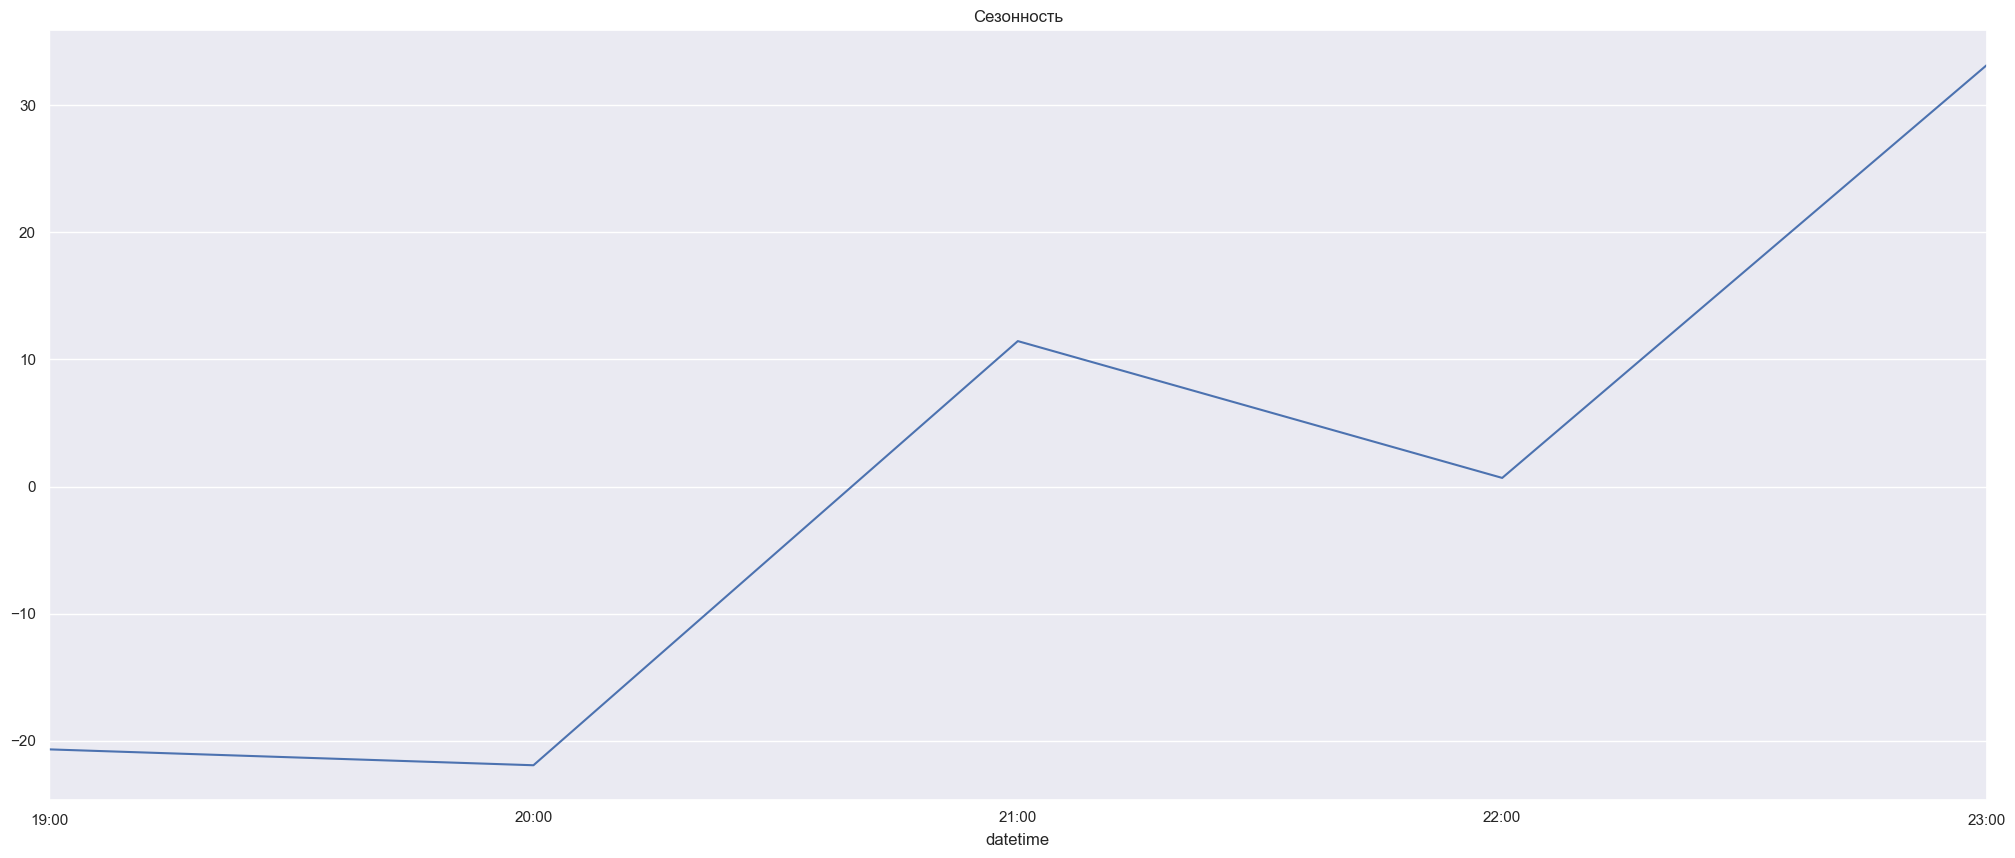

In [22]:
lineplot(decomposed_aug.seasonal.tail(), 'Сезонность')

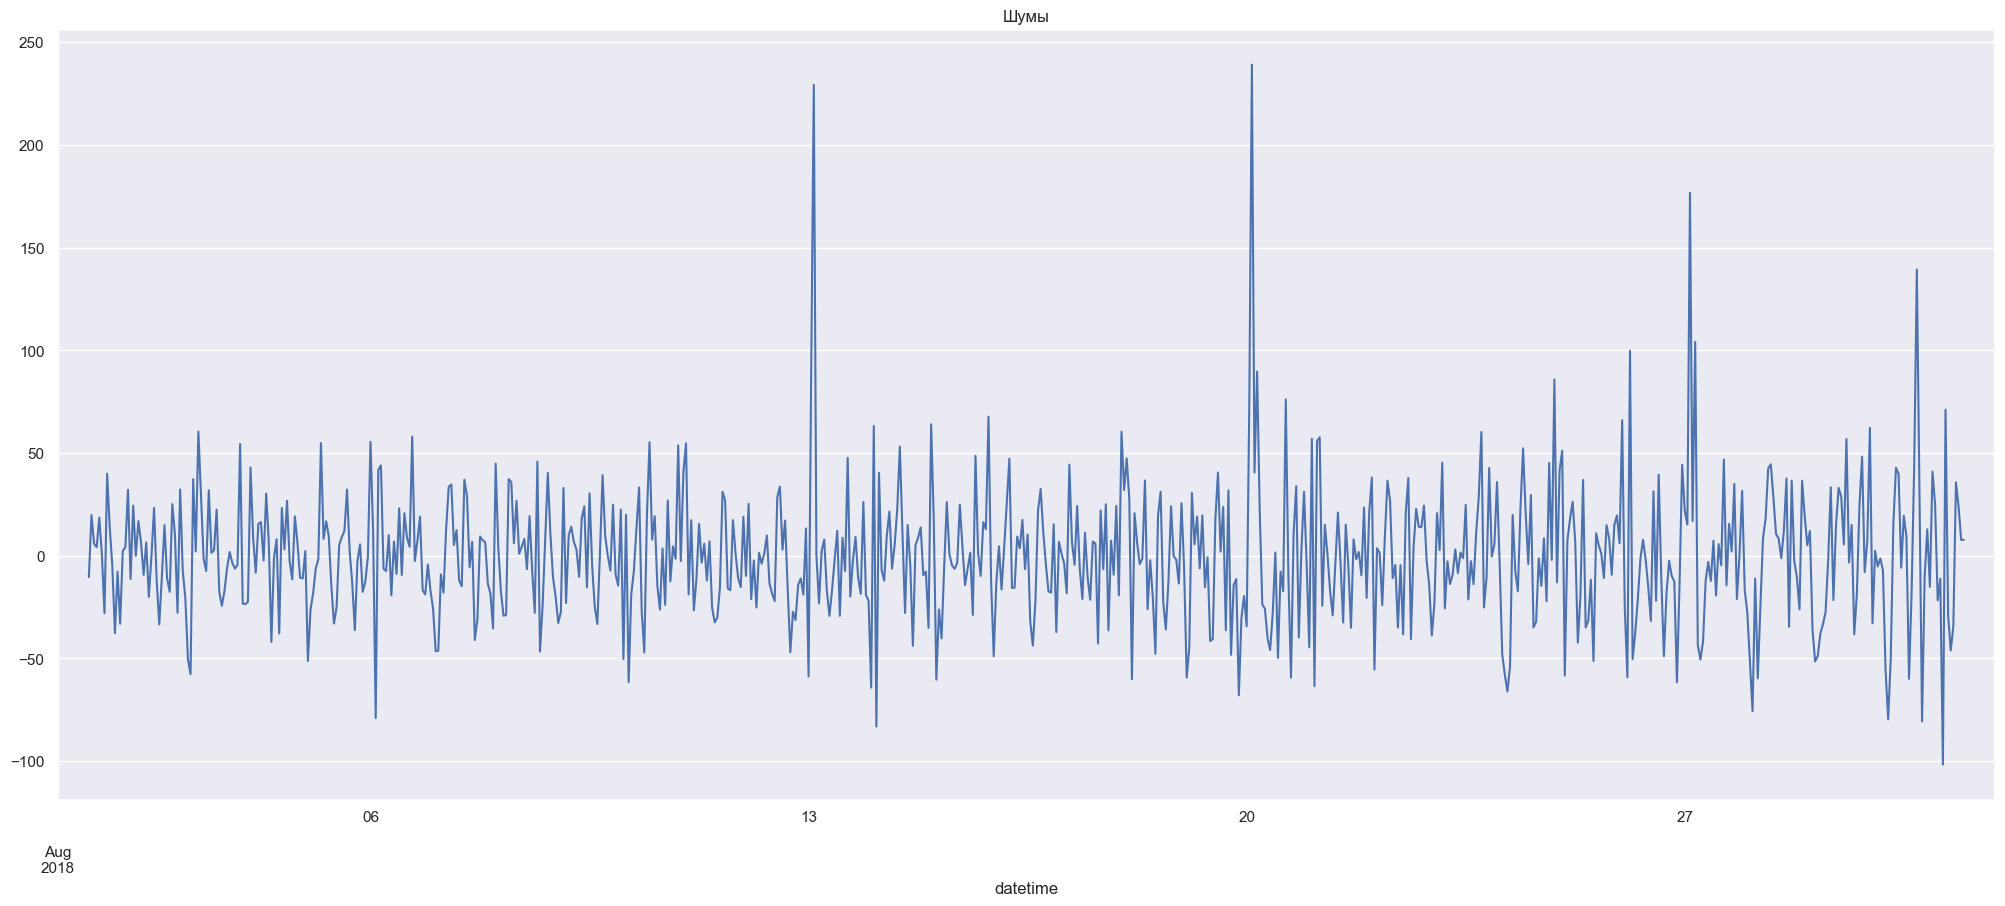

In [23]:
lineplot(decomposed_aug.resid, 'Шумы')

Выводы:
- Наблюдается тренд равномерного роста заказов с периодическими небольшими падениями как на общем промежутке времени так и в разерезе 1 месяца
- Присутствует сезонность по дням - спад ночью, рост с утра и днем, пик к вечеру
- Временной ряд стационарный

# Обучение

## Подготовка данных

In [24]:
#функция по добавлению столбца год, месяц, день, лаг, среднее скользящее
def data_prepare(data, rolling):
    df_new = data.copy()
    #data['year'] = data.index.year #добавление столбца год
    df_new['month'] = data.index.month #добавление столбца месяц
    df_new['day'] = data.index.day #добавление столбца день
    df_new['hour'] = data.index.hour #добавдление столбца часа
    df_new['dayofweek'] = data.index.dayofweek #добавление столбца день недели
    for lag in range(1, 25):
        data[f'lag_{lag}'] = df_new.num_orders.shift(lag) #добавление столбцов лага
    data['rolling_mean'] = df_new['num_orders'].shift().rolling(rolling).mean() #добавление столбца среднего скользящего
    return df_new

In [25]:
data_prepare(data, 10) #переменные для ввода: данные, и окно среднего скользящего

num_orders  month  day  hour  dayofweek
datetime                                                    
2018-03-01 00:00:00         124      3    1     0          3
2018-03-01 01:00:00          85      3    1     1          3
2018-03-01 02:00:00          71      3    1     2          3
2018-03-01 03:00:00          66      3    1     3          3
2018-03-01 04:00:00          43      3    1     4          3
...                         ...    ...  ...   ...        ...
2018-08-31 19:00:00         136      8   31    19          4
2018-08-31 20:00:00         154      8   31    20          4
2018-08-31 21:00:00         159      8   31    21          4
2018-08-31 22:00:00         223      8   31    22          4
2018-08-31 23:00:00         205      8   31    23          4

[4416 rows x 5 columns]

In [26]:
train, test = train_test_split(data, shuffle=False, test_size=0.1) #установление тестовой выборки в 10%

In [27]:
train = train.dropna()

In [28]:
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

## Подготовка к подбору гиперпараметров

In [29]:
def objective(trial):
    classifier_name = trial.suggest_categorical('regressor', ['RandomForestRegressor', 'XGBoost', 'LinearRegression'])
    if classifier_name == 'RandomForestRegressor': #параметры для модели RandomForestRegressor
        rfr_estimator = trial.suggest_int('n_estimator', 100, 150) # параметр количества деревьев от 100 до 150
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32) # параметр глубины дерева от 2 до 32
        classifier_obj = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=rfr_estimator) # создание модели
    elif classifier_name == 'XGBoost': # параметры для модели SGBoost
        xgb_depth = trial.suggest_int('max_depth', 6, 30, log=True) #параметр глубины дерева, от 6 до 30
        xgb_est = trial.suggest_int('n_estimators', 400, 1000) #параметр количества деревьев, от 400 до 1000
        xgb_lr = trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]) #параметр скорости обучения
        classifier_obj = xgb.XGBRegressor(max_depth=xgb_depth, n_estimators=xgb_est , learning_rate=xgb_lr) #созданик модели
    elif classifier_name == 'LinearRegression': #параметры для Линейной Регрессии
        classifier_obj = LinearRegression()
        
    classifier_obj.fit(X_train, y_train)    #обучение модели
    score = root_mean_squared_error(y_test, classifier_obj.predict(X_test)) #вычисление метрики
    
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()
    

    return score

In [30]:
%%time
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=25)

[I 2024-03-24 19:40:06,718] A new study created in memory with name: no-name-d46e9d9d-9360-4e9b-9fef-58b38a45c3eb


CPU times: user 5min 32s, sys: 1min 4s, total: 6min 37s
Wall time: 2min 50s


In [31]:
study.best_trial.values

[41.880375522859055]

In [32]:
study.best_params

{'regressor': 'RandomForestRegressor', 'n_estimator': 103, 'rf_max_depth': 22}

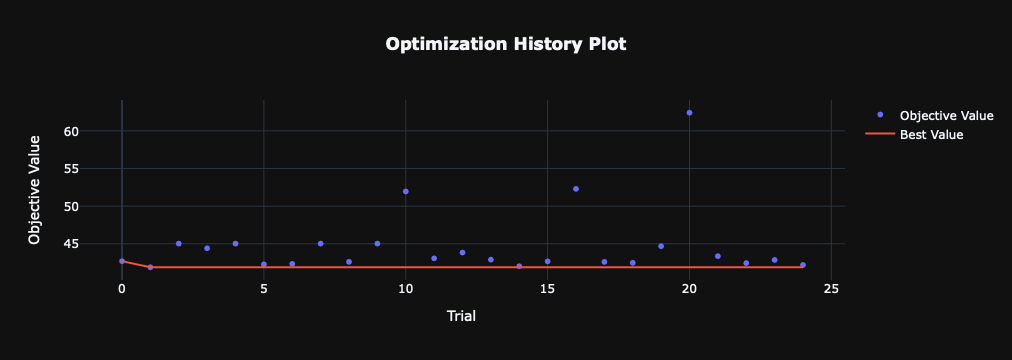

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

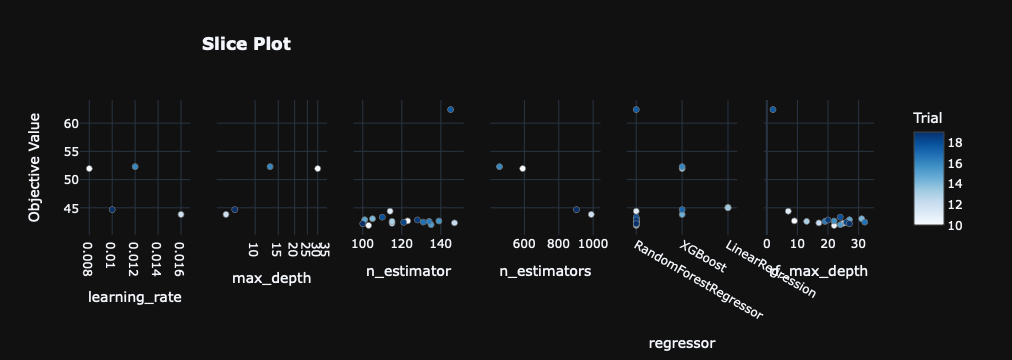

In [34]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)

In [35]:
model = RandomForestRegressor(n_estimators=142, max_depth=16)

In [36]:
%%time
model.fit(X_train, y_train)

CPU times: user 8.47 s, sys: 11.1 ms, total: 8.48 s
Wall time: 8.5 s


RandomForestRegressor(max_depth=16, n_estimators=142)

In [37]:
%%time
predict = model.predict(X_test)

CPU times: user 13.3 ms, sys: 1.31 ms, total: 14.6 ms
Wall time: 13.7 ms


In [41]:
print(f'Final RMSE equal {root_mean_squared_error(y_test, predict)}')

Final RMSE equal 42.133797762531884


## Сравнение данных обучения и исходных

In [42]:
pred_test = pd.DataFrame()

In [43]:
pred_test['y_test'] = y_test

In [44]:
pred_test['y_pred'] = predict

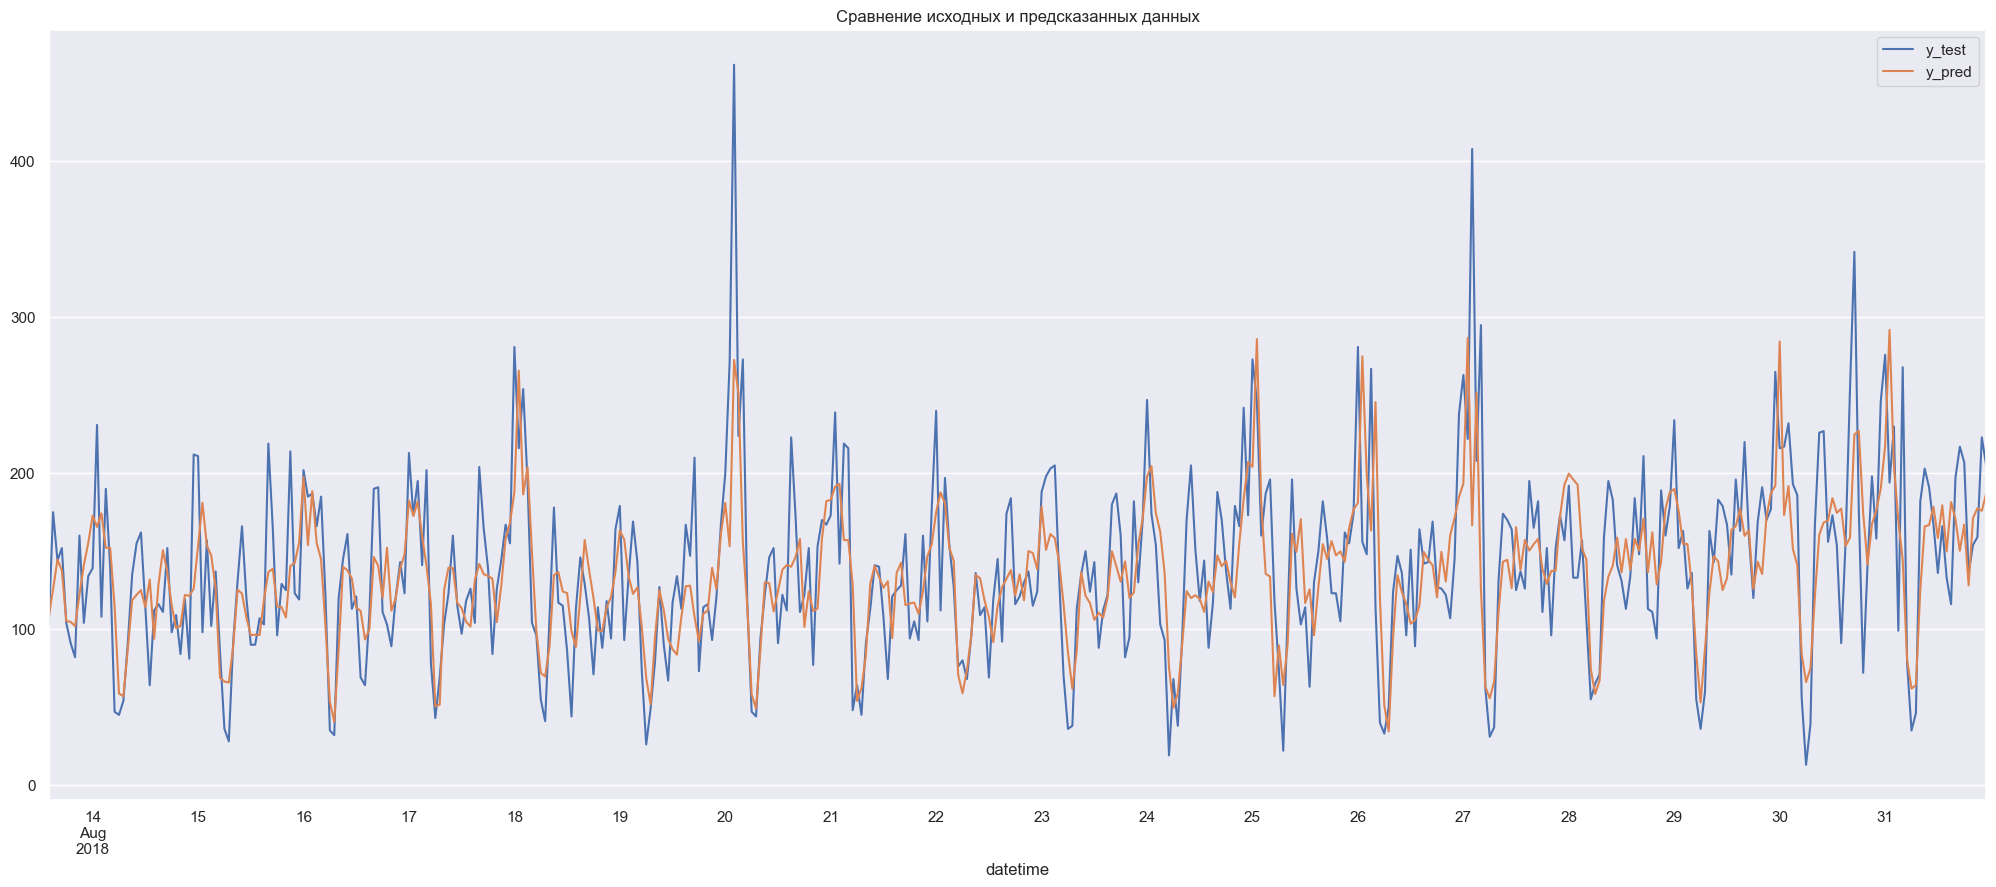

In [45]:
pred_test.plot()
plt.title('Сравнение исходных и предсказанных данных')
plt.show()

# Выводы

В процессе обучения, метрики:
- LogisticRegressionRandom
- ForestRegressor
- XGBoost
- LinearRegression  
показали метрику `RMSE` менее 48, как и требовалось по условиям заказчика, модели на основании `RandomForestRegressor` по итогам дает наилучшую метрику.

Так же график наглядно показывает, что глобальных отклонений в предсказанных данных нет, а также учитывается сезонность и нагрузка по заказу машин.